Case (i): A is an identity matrix and n is Gaussian noise. ( the denoising problem)

1) Wiener Filter

PSNR of Original Image: inf
PSNR of Noisy Image: 28.097368778458318
PSNR of Denoised Image (Wiener Filter): 10.781770921892726


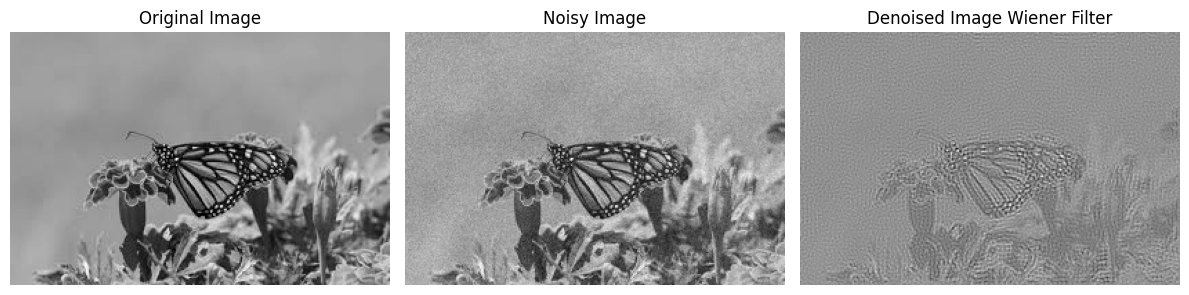

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.metrics import peak_signal_noise_ratio

image = cv2.imread('/content/images.jpeg', cv2.IMREAD_GRAYSCALE)

# Noise parameters
mean = 0
var = 100
sigma = var ** 0.5

# Gaussian noise
gaussian_noise = np.random.normal(mean, sigma, image.shape)

noisy_image = np.float32(image) + gaussian_noise

def wiener_filter(noisy_image, kernel_size, noise_var):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
    noise_var *= np.mean(noisy_image.var())
    kernel_fft = np.fft.fft2(kernel, noisy_image.shape)
    noisy_fft = np.fft.fft2(noisy_image)
    wiener_fft = np.conj(kernel_fft) / (np.abs(kernel_fft)**2 + noise_var / np.abs(noisy_fft)**2)
    wiener_image = np.fft.ifft2(noisy_fft * wiener_fft).real
    return wiener_image

denoised_image = wiener_filter(noisy_image, kernel_size=3, noise_var=sigma**2)

# PSNR
psnr_value = peak_signal_noise_ratio(image, denoised_image)

plt.figure(figsize=(12, 8))

psnr_original = peak_signal_noise_ratio(image, image)
psnr_noisy = peak_signal_noise_ratio(image, noisy_image)
psnr_denoised = peak_signal_noise_ratio(image, denoised_image)

print("PSNR of Original Image:", psnr_original)
print("PSNR of Noisy Image:", psnr_noisy)
print("PSNR of Denoised Image (Wiener Filter):", psnr_denoised)

plt.subplot(131)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Noisy Image')
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Denoised Image Wiener Filter')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


2) MAP estimation

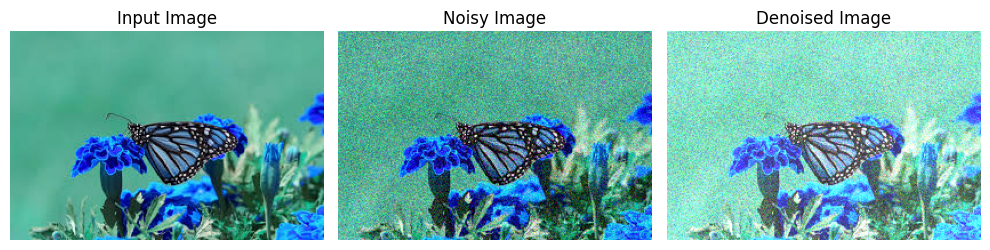

In [41]:
from skimage.util import random_noise

def map_estimation(noisy_image, noise_var, prior_mean, prior_var):

    denoised_image = np.zeros_like(noisy_image)

    for i in range(noisy_image.shape[0]):
        for j in range(noisy_image.shape[1]):
            noisy_pixel = noisy_image[i, j]
            likelihood_precision = 1 / noise_var
            prior_precision = 1 / prior_var

            # Posterior precision and mean
            posterior_precision = prior_precision + likelihood_precision
            posterior_mean = (prior_precision * prior_mean + likelihood_precision * noisy_pixel) / posterior_precision

            denoised_image[i, j] = posterior_mean

    return denoised_image

ximage = cv2.imread('/content/images.jpeg')


sigma = 0.1
noisy_image = random_noise(ximage, mode='gaussian', var=sigma**2)


mu_prior = np.mean(image)
sigma_prior = np.std(image)
sigma_var = 0.1


denoised_image = map_estimation(noisy_image, sigma_var, mu_prior, sigma_prior)


plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

3) Deep Network Approach

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 30463.8477
Epoch 2/50
1/1 [==============================] - 1s 745ms/step - loss: 19426.0391
Epoch 3/50
1/1 [==============================] - 1s 908ms/step - loss: 12417.0225
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 7059.0000
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 3018.0435
Epoch 6/50
1/1 [==============================] - 1s 764ms/step - loss: 647.5128
Epoch 7/50
1/1 [==============================] - 1s 740ms/step - loss: 570.3071
Epoch 8/50
1/1 [==============================] - 1s 712ms/step - loss: 2133.1865
Epoch 9/50
1/1 [==============================] - 1s 731ms/step - loss: 3130.8950
Epoch 10/50
1/1 [==============================] - 1s 750ms/step - loss: 3056.1509
Epoch 11/50
1/1 [==============================] - 1s 720ms/step - loss: 2341.0220
Epoch 12/50
1/1 [==============================] - 1s 722ms/step - loss: 1455.3062
Epoch 13/50
1/1 [====

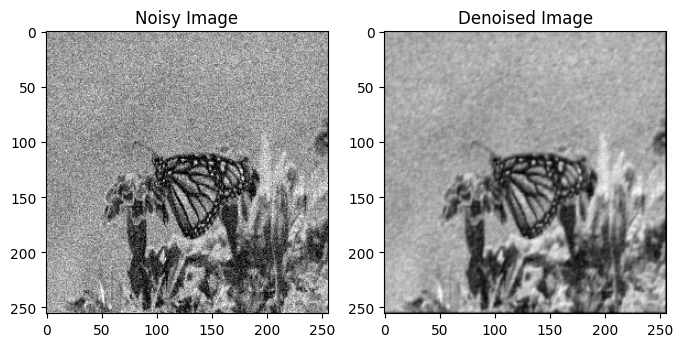

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D


image = cv2.imread('/content/images.jpeg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))

# Gaussian noise
noise = np.random.normal(0, 25, image.shape)
noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')


model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(image.shape[0], image.shape[1], 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(1, (3, 3), activation='linear', padding='same')
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(noisy_image.reshape(1, *noisy_image.shape, 1), image.reshape(1, *image.shape, 1), epochs=50)


denoised_image = model.predict(noisy_image.reshape(1, *noisy_image.shape, 1)).reshape(image.shape)


plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')

plt.show()


Case(II): A is a matrix derived out of assuming some camera shake. For solutions using MAP and deep network based approach assume that A is unknown ( A blind deconvolution problem.

1) Wiener Filter

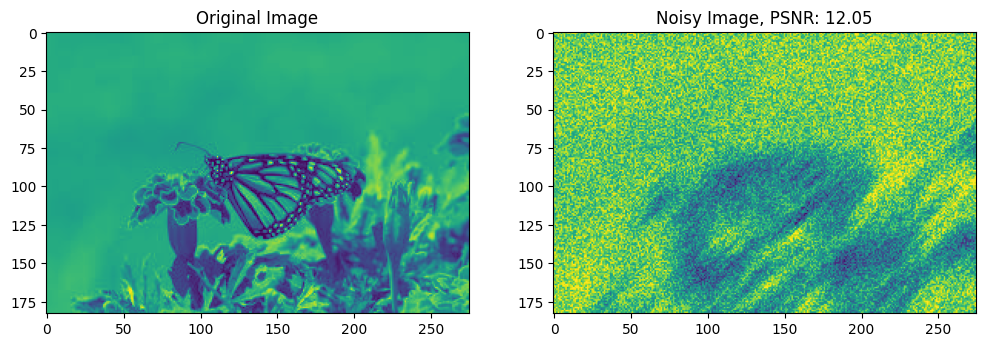

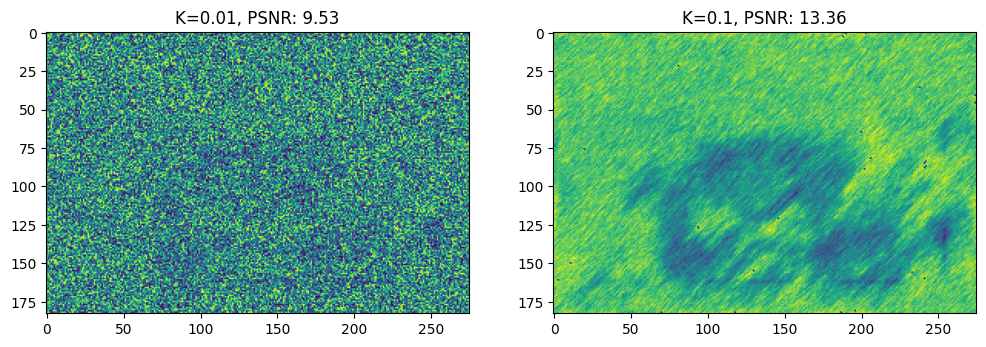

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# Reading the input image
f_image = cv2.imread("/content/images.jpeg", cv2.IMREAD_GRAYSCALE)

# Function to add uniform noise to the image
def add_noise(image, intensity=100): return np.clip(np.random.rand(*image.shape) * intensity + image, 0, 255).astype(np.uint8)

# Generating a kernel matrix
def gen_kernel(n): return np.array([[1 if i == n - j - 1 else 0 for j in range(n)] for i in range(n)], dtype=np.float32) / n

# Applying the kernel to the image with added noise
g_image = add_noise(cv2.filter2D(f_image, -1, gen_kernel(21)))

# Plotting images
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.title("Original Image"); plt.imshow(f_image)
plt.subplot(1, 2, 2); plt.title("Noisy Image, PSNR: {:.2f}".format(psnr(f_image, g_image))); plt.imshow(g_image)
plt.show()

# Wiener filter function
def wiener_filter(img, kernel, K):
    fft_img, fft_kernel = np.fft.fft2(img), np.fft.fft2(kernel, s=img.shape)
    fft_H = np.conj(fft_kernel) / (np.abs(fft_kernel)**2 + K * np.ones(fft_kernel.shape))
    return np.abs(np.fft.ifft2(fft_img * fft_H)).astype(np.uint8)

# Applying Wiener filter with different parameters
f_estimate_1 = wiener_filter(g_image, gen_kernel(21), 0.01)
f_estimate_2 = wiener_filter(g_image, gen_kernel(21), 0.1)

# Plotting filtered images
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.title("K=0.01, PSNR: {:.2f}".format(psnr(f_image, f_estimate_1))); plt.imshow(f_estimate_1);
plt.subplot(1, 2, 2); plt.title("K=0.1, PSNR: {:.2f}".format(psnr(f_image, f_estimate_2))); plt.imshow(f_estimate_2);
plt.show()


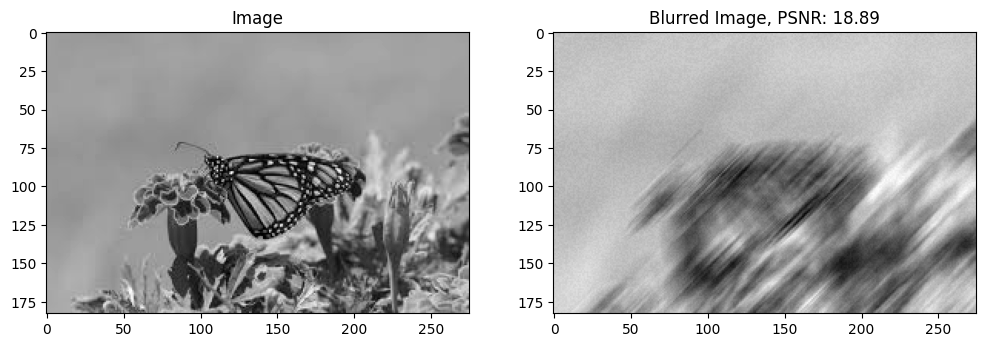

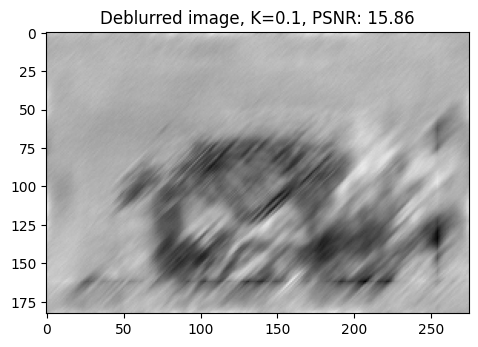

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric


orig_img = cv2.imread("/content/images.jpeg", cv2.IMREAD_GRAYSCALE)


def apply_noise(image, intensity=10): return np.clip(np.random.rand(*image.shape) * intensity + image, 0, 255).astype(np.uint8)


def generate_kernel(n): return np.array([[1 if i == n - j - 1 else 0 for j in range(n)] for i in range(n)], dtype=np.float32) / n


noisy_img = apply_noise(cv2.filter2D(orig_img, -1, generate_kernel(21)))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.title("Image"); plt.imshow(orig_img, cmap='gray')
plt.subplot(1, 2, 2); plt.title("Blurred Image, PSNR: {:.2f}".format(psnr_metric(orig_img, noisy_img))); plt.imshow(noisy_img, cmap='gray')
plt.show()

# Wiener filter function
def apply_wiener_filter(img, kernel, K):
    fft_img, fft_kernel = np.fft.fft2(img), np.fft.fft2(kernel, s=img.shape)
    fft_H = np.conj(fft_kernel) / (np.abs(fft_kernel)**2 + K * np.ones(fft_kernel.shape))
    return np.abs(np.fft.ifft2(fft_img * fft_H)).astype(np.uint8)

wiener_est = apply_wiener_filter(noisy_img, generate_kernel(21), 0.1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2); plt.title("Deblurred image, K=0.1, PSNR: {:.2f}".format(psnr_metric(orig_img, wiener_est))); plt.imshow(wiener_est, cmap='gray');
plt.show()


2) MAP estimation

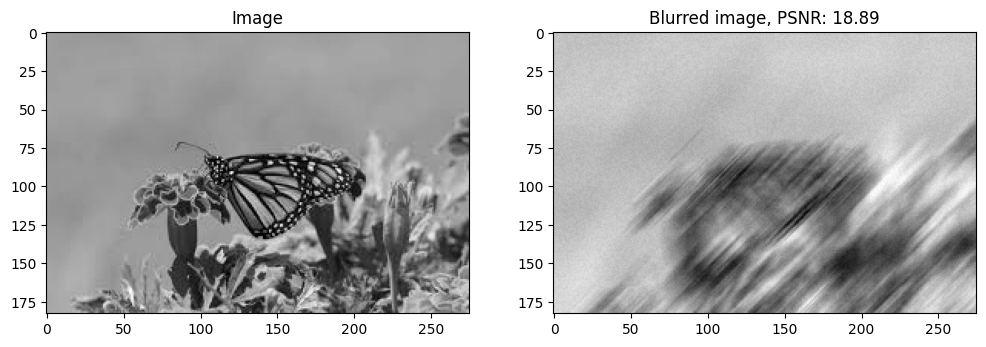

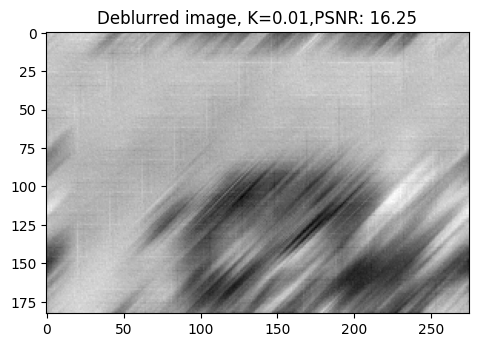

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric

orig_img = cv2.imread("/content/images.jpeg", cv2.IMREAD_GRAYSCALE)

# uniform noise
def apply_noise(image, intensity=10): return np.clip(np.random.rand(*image.shape) * intensity + image, 0, 255).astype(np.uint8)

# kernel matrix
def generate_kernel(n): return np.array([[1 if i == n - j - 1 else 0 for j in range(n)] for i in range(n)], dtype=np.float32) / n

noisy_img = apply_noise(cv2.filter2D(orig_img, -1, generate_kernel(21)))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.title("Image"); plt.imshow(orig_img, cmap='gray')
plt.subplot(1, 2, 2); plt.title("Blurred image, PSNR: {:.2f}".format(psnr_metric(orig_img, noisy_img))); plt.imshow(noisy_img, cmap='gray')
plt.show()

# MAP estimation function
def apply_map_estimation(img, kernel, K, beta):
    fft_img, fft_kernel = np.fft.fft2(img), np.fft.fft2(kernel, s=img.shape)
    fft_H = np.conj(fft_kernel) / (np.abs(fft_kernel)**2 + K * np.ones(fft_kernel.shape))
    map_filtered_freq = (np.conj(fft_H) * fft_img) / (np.abs(fft_H)**2 + beta * np.ones(fft_H.shape))
    return np.abs(np.fft.ifft2(map_filtered_freq)).astype(np.uint8)

map_est = apply_map_estimation(noisy_img, generate_kernel(21), 0.01, 0.01)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.title("Deblurred image, K=0.01,PSNR: {:.2f}".format(psnr_metric(orig_img, map_est))); plt.imshow(map_est, cmap='gray');
plt.show()


3) Deep Network

Epoch 1/50
1/1 [==============================] - 34s 34s/step - loss: 25830.3945
Epoch 2/50
1/1 [==============================] - 1s 930ms/step - loss: 15870.0752
Epoch 3/50
1/1 [==============================] - 1s 940ms/step - loss: 8210.4189
Epoch 4/50
1/1 [==============================] - 1s 923ms/step - loss: 3043.6851
Epoch 5/50
1/1 [==============================] - 1s 959ms/step - loss: 693.4946
Epoch 6/50
1/1 [==============================] - 1s 928ms/step - loss: 1459.5515
Epoch 7/50
1/1 [==============================] - 1s 917ms/step - loss: 3352.8984
Epoch 8/50
1/1 [==============================] - 1s 944ms/step - loss: 3915.0142
Epoch 9/50
1/1 [==============================] - 1s 1s/step - loss: 3164.4749
Epoch 10/50
1/1 [==============================] - 1s 1s/step - loss: 1994.2999
Epoch 11/50
1/1 [==============================] - 1s 1s/step - loss: 1095.8447
Epoch 12/50
1/1 [==============================] - 1s 896ms/step - loss: 661.0104
Epoch 13/50
1/1 [======

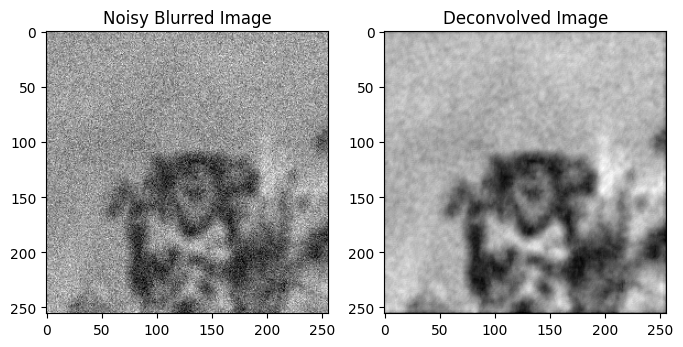

In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D


image = cv2.imread('/content/images.jpeg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))

# Blur kernel
kernel_size = 11
blur_kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
blurred_image = cv2.filter2D(image, -1, blur_kernel)

# Gaussian noise
noise = np.random.normal(0, 25, image.shape)
noisy_blurred_image = np.clip(blurred_image + noise, 0, 255).astype(np.uint8)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(noisy_blurred_image, cmap='gray')
plt.title('Noisy Blurred Image')

# DDeconvolution CNN
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(image.shape[0], image.shape[1], 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(1, (3, 3), activation='linear', padding='same')
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(noisy_blurred_image.reshape(1, *noisy_blurred_image.shape, 1), image.reshape(1, *image.shape, 1), epochs=50)

deconvolved_image = model.predict(noisy_blurred_image.reshape(1, *noisy_blurred_image.shape, 1)).reshape(image.shape)

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_image, cmap='gray')
plt.title('Deconvolved Image')

plt.show()
